# 236756 - Machine Learning - Exercise 5
### Ron Sailer
### Adam Erdreich

# Loading the data

The train and test sets have already been preprocessed so we can load and use them as-is.

For the entirety of the assignment, we will treat the new data and the validation set the same. They will be imputed the same way, scaled the same way and so on. This will allow us to simulate to the best of our abilities our predictions.

### Just loading some modules...

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


#classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100) # to display all columns at all time
pd.options.mode.chained_assignment = None # to ignore false-positive warnings about chained assignments
from repoze.lru import lru_cache # user-implemented lru_cache attribute, similar to standrad one in python 3.3


In [2]:
data = pd.read_csv('ElectionsData.csv',header=0)

train_test = pd.read_csv('modified/afterpp_train_test2.csv',header=0)
validation = pd.read_csv('original/orig_validation.csv', header=0)

new_data = pd.read_csv('new_data/ElectionsData_Pred_Features.csv', header=0)

# merged train and test

for df in [train_test, validation, new_data]:
    df.drop([x for x in df.columns.values if 'Unnamed' in x],axis=1,inplace=True)

In [3]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7750 entries, 0 to 7749
Data columns (total 15 columns):
Vote                                    7750 non-null object
Yearly_ExpensesK                        7750 non-null float64
Yearly_IncomeK                          7750 non-null float64
Overall_happiness_score                 7750 non-null float64
Avg_Residancy_Altitude                  7750 non-null float64
Most_Important_Issue_Education          7750 non-null int64
Most_Important_Issue_Environment        7750 non-null int64
Most_Important_Issue_Financial          7750 non-null int64
Most_Important_Issue_Foreign_Affairs    7750 non-null int64
Most_Important_Issue_Healthcare         7750 non-null int64
Most_Important_Issue_Military           7750 non-null int64
Most_Important_Issue_Other              7750 non-null int64
Most_Important_Issue_Social             7750 non-null int64
Will_vote_only_large_party              7750 non-null float64
Financial_agenda_matters                77

## Preprocessing the new data and the Validation set

first, we want to "hide" unwanted colums from each dataset:
validation - has the "Vote" column
new_data - has the "IdentityCard_Num" column.

we will remove those for the imputation process, and glue them back after we're done.

In [4]:
validation_labels = validation['Vote']
new_data_IDs = new_data['IdentityCard_Num']

validation = validation.drop(['Vote'],axis=1)
new_data = new_data.drop(['IdentityCard_Num'],axis=1)

#### Some helper functions...

These are all from previous homework assignments. No point in reading the code, documentation will be provided when calling the functions.

In [5]:
def count_categories(attr):
    return len(data[attr].astype('category').cat.categories)

obj_attr = [(col, count_categories(col))  for col in data if data[col].dtype==np.object and col != 'Vote']
obj_attr_names = map(lambda x: x[0], obj_attr)
num_attr = [col  for col in data if data[col].dtype==np.float64]
        
def get_nan_per_row_counter(df):
    return Counter(df.isnull().sum(axis=1).tolist())

def plot_pie_nan_per_row(df):
    counter = get_nan_per_row_counter(df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral'],
            explode = [0.1] * len(histogram),
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p)
           )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
    
### Pearson's Correlation coefficient:

def get_most_correlated(corr_mat, col, thresh):
    res = corr_mat[col].reindex(corr_mat[col].abs().sort_values(ascending=False).index)
    res = res[res.index != col]
    return res[res >= thresh]

def pearson_impute(df):
    pearson_coeff_thresh = 0.95

    pearson = df.corr(method='pearson')

    # a dict mapping each feature with its 3 most-correlated features, only if the corr with the best of them is >=0.9 (in abs value)
    sorted_pearson_per_col = {col: \
                              get_most_correlated(pearson, col, pearson_coeff_thresh) for col in pearson\
                             if get_most_correlated(pearson, col, pearson_coeff_thresh).any()}

    df_copy = df.copy()

    for col, top_corr_cols in sorted_pearson_per_col.iteritems():
        for corr_col in top_corr_cols.index:
            ratio = (df_copy[col] / df_copy[corr_col]).mean()
            cols = df_copy[[col, corr_col]]
            cols[corr_col] = cols[corr_col].map(lambda x: x*ratio)
            df[col].fillna(cols[corr_col], inplace=True)
    plot_pie_nan_per_row(df)
    return df

def __test_accuracy(df, attr='Vote',num_of_iterations=5):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values
    avg_accuracy = 0
    for i in range(num_of_iterations):
        # Prepare train and test data using cross validation
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_X,train_data_Y)

        forest = RandomForestClassifier(n_estimators = 10)
        clf = forest.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        avg_accuracy += metrics.accuracy_score(Y_test, Y_pred)
    print attr+" accuracy:", avg_accuracy/num_of_iterations
    return avg_accuracy/num_of_iterations

def _train_classifier_on_feature(df, attr, verbose):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values
    
    if verbose:
        __test_accuracy(df,attr)
        
    forest = RandomForestClassifier(n_estimators = 10)
    return forest.fit(train_data_X, train_data_Y)


def _prepare_for_impute(df, attr, count, verbose):
    df_tmp = df.copy()
    for a,c in [(x,y) for x,y in obj_attr if x != attr]:
        df_tmp = pd.concat([df_tmp,pd.get_dummies(df_tmp[a],prefix=a,dummy_na=True)], axis=1)
        df_tmp = df_tmp.drop([a],axis=1)
    #drop all rows with nan in certain column
    df_tmp_noNaN = df_tmp.dropna(subset=[attr],axis=0)
    to_classify = df_tmp[pd.isnull(df_tmp[attr])].drop([attr],axis=1)
    clf = _train_classifier_on_feature(df_tmp_noNaN,attr,verbose)
    return to_classify, clf


def impute_categories(df, verbose=False):
    to_classify = None
    results = {}

    for attr, count in obj_attr:
        to_classify, clf = _prepare_for_impute(df, attr, count, verbose)
        if to_classify.shape[0] > 0:
            results[attr] = list(clf.predict(to_classify))
            if verbose:
                print results[attr]
    for attr, res in results.iteritems():
        j = 0
        for i in df.index.values:
            if df[attr][i] is not np.nan:
                continue
            df[attr][i] = results[attr][j]
            j += 1
    return df

def numerize(df):
    for attr in ['Financial_agenda_matters','Will_vote_only_large_party']:
        df[attr] = df[attr].map({'No':0, 'Yes':1}).astype(float)
        
    # Handle categorical columns and add one-hot vectors
    for attr in ['Most_Important_Issue']:
        df = pd.concat([df, pd.get_dummies(df[attr],prefix=attr)], axis=1)
        df = df.drop([attr],axis=1)
        
    return df

def _train_regressor_on_feature(df, attr):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values

    forest = RandomForestRegressor(n_estimators = 100)
      
    return forest.fit(train_data_X, train_data_Y)


def _prepare_for_regression(df, attr):
    df_tmp = df.copy()
    #convert all categorical features to one-hot vectors because otherwise we are stuck with strings
    for a,c in [x for x in obj_attr if x[0] != attr]:
        df_tmp = pd.concat([df_tmp,pd.get_dummies(df_tmp[a],prefix=a,dummy_na=True)], axis=1)
        df_tmp = df_tmp.drop([a],axis=1)
    #drop all rows with nan
    df_tmp_noNaN = df_tmp.dropna()
    #get the rows to impute
    to_regress = df_tmp[pd.isnull(df_tmp[attr])].drop([attr],axis=1)
    #train a regressor to impute these rows
    regressor = _train_regressor_on_feature(df_tmp_noNaN,attr)
    return to_regress, regressor


def impute_numerical(df, verbose=False):
    to_regress = None
    results = {}
    
    #go over all numerical attributes
    for attr in num_attr:
        if verbose:
            print attr
        to_keep = [df.loc[k].isnull().sum() < 2 for k in df.index.values]
        df_no_multiple_nan = df.loc[to_keep]
        #get regressor for that problem
        to_regress, regressor = _prepare_for_regression(df_no_multiple_nan, attr)
        #if there are things to impute
        if to_regress.shape[0] > 0:
            #get a list of the regressor results
            results[attr] = list(regressor.predict(to_regress))
            if verbose:
                print results[attr]
    #fill in the missing values
    for attr, res in results.iteritems():
        j = 0
        for i in df.index.values:
            if np.isnan(df[attr][i]) == False or df.loc[i].isnull().sum() > 1:
                continue
            df[attr][i] = results[attr][j]
            j += 1
    return df

First, let's see what we're dealing with...

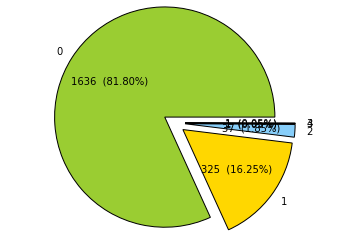

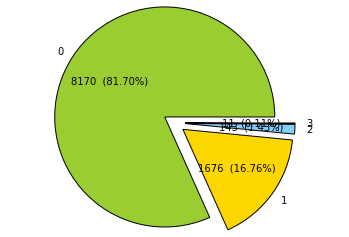

In [6]:
plot_pie_nan_per_row(validation)
plot_pie_nan_per_row(new_data)

## Using Pearson's Correlation Coefficient

We've set a threshold of 0.95 for the pearson's correlation coefficient. Any two features with a value of that and above will be considered "highly correlated" and will be used to impute each other by taking the mean ratio between the values of those columns, multiplying the value from one column by that ratio (or its inverse) and assigning it to the other column where there is a missing value.

Because most of the columns are either complete or have at most 1 missing value, this will be a very useful tool.

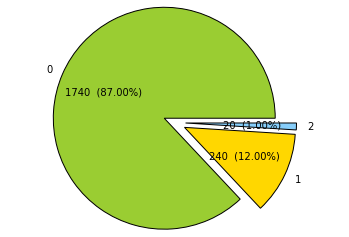

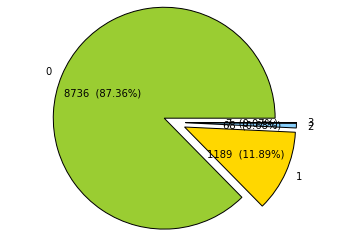

In [7]:
validation = pearson_impute(validation)
new_data = pearson_impute(new_data)

In [8]:
validation = impute_numerical(validation,True)
new_data = impute_numerical(new_data,True)

Occupation_Satisfaction
[6.1699999999999999, 5.2999999999999998, 5.4500000000000002, 5.4299999999999997, 5.1299999999999999, 5.8200000000000003, 5.1600000000000001, 4.5899999999999999, 5.4900000000000002, 5.3399999999999999, 6.1200000000000001, 5.4699999999999998, 6.4100000000000001]
Avg_monthly_expense_when_under_age_21
AVG_lottary_expanses
[152678.41669391, 30532.241417992002, 102368.03087697498, 13045.1483396979, 134338.91547092993, -19206.895275297822, 136933.77043894006, 147267.17086315007]
Avg_Residancy_Altitude
Yearly_ExpensesK
Financial_balance_score_(0-1)
[0.45324011611749221, 0.49762180022776326, 0.55947637461991073, 0.48924600434723708, 0.52472422653572703, 0.50145667390933935, 0.45226371565872225, 0.39956897098491789, 0.45537313803560309, 0.39618365476492506, 0.55144976878096519]
%Of_Household_Income
[0.55140972637919694, 0.51608119283172027, 0.57150665170632176, 0.47377608022345846, 0.53889431975825974, 0.42014849264173576, 0.48742734138733579, 0.49336436186489052, 0.47884

[4.6011075248410007, 5.5942856871750015, 5.0189009858789992, 4.5389450445810002, 4.0837383148019999, 5.0212740240140006, 5.5411543074730023, 4.4952978804960013, 4.1094226636479991, 4.6295490688670036, 4.8572584647459998, 4.3956165838290016, 4.7067496703209981, 4.3425501440700005, 4.8691956290719993, 5.324891468833, 4.1467393489049984, 5.2158223527909975, 4.7438772997299994, 4.9918315213410009, 4.7118290562409975, 5.1199178879180014, 4.9777166307669996, 5.0392771541890005, 4.8744740273769995, 4.8595886816710001, 4.4868349052739989, 5.2784035723919986, 4.728803816159, 5.1946446205250023, 5.1404891862039985, 5.1897521422680022, 5.2469337434989995, 4.874920540789998, 4.8909960628199993, 4.6977560600770003, 4.0609431846310011, 5.187718518854, 3.8960972427400007, 4.3757735484960003, 5.5244534093179993, 5.2473279474360002, 5.102402410028998, 5.1129372040519998, 4.5211127232673318, 5.2088120401109981, 5.2775668074170001, 4.9018803126479984, 4.2737387958260005, 4.6139821376149985, 5.18480210532

[153253.79512934724, 27461.113187744344, 36118.40981454603, 15937.011656562099, 26283.605014593351, 6495.4028978666647, 22195.180738306222, 6736.7909957038219, 3196.3516385352455, 33620.764691823693, 25269.833462783168, 9245.9343324702895, 2728.3246856109768, 52647.685980335213, 45673.495148652772, 76168.342466622256, 66349.218426896143, 110067.9694468602, 117582.469032327, 1824.822080840645, 1889.0500467517143, 25943.01075550462, 891.77237764692927, 25.40823406616002, 15980.96220046819, 84707.230861979333, 16148.291303628099, 304575.01149783604, 3648.7641003553267, 7502.8619963421033, 94442.991935015933, 10483.036356898318, 10557.812407867073, 6941.6635289153601, 2989.8067514837235, 1383.9186087884, 3498.2018961929793, 24428.069250110886, 676.01483433919134, 58460.548484811989, 59314.471238552171, 109654.30655445829, 65.985620076868969, 4233.0325441234063, 38708.568961614968, 136680.87860398839, 10638.587725454274, 21091.196112480375, 90431.097433190676, 81356.444316852416, 8064.75356

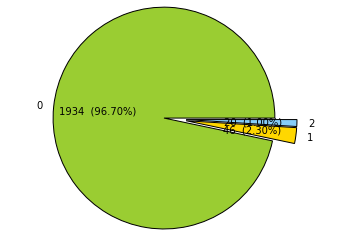

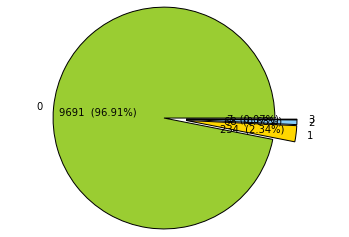

In [9]:
plot_pie_nan_per_row(validation)
plot_pie_nan_per_row(new_data)

## Impute the rest

We now tried to find a method to properly impute all other missing data, while taking into account mostly the preservation of relations between features, to best fit our mission of applying machine-learning on the data.

we considered EM as taught in the lectures, but found the assumption of Multivariate-Gaussian distribution to mostly incorrect when it comes to our data.

after looking for a while, and considering different methods, we have decided to use SoftImpute, based on this paper: http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf.

"SoftImpute" also conviniently has an open-source implementation in Python.

[SoftImpute] Max Singular Value of X_init = 42339989.782595
[SoftImpute] Iter 1: observed MAE=2514.340383 rank=4
[SoftImpute] Iter 2: observed MAE=2514.260330 rank=4
[SoftImpute] Iter 3: observed MAE=2514.291217 rank=4
[SoftImpute] Iter 4: observed MAE=2514.280311 rank=4
[SoftImpute] Iter 5: observed MAE=2514.293256 rank=4
[SoftImpute] Iter 6: observed MAE=2514.304322 rank=4
[SoftImpute] Iter 7: observed MAE=2514.309193 rank=4
[SoftImpute] Iter 8: observed MAE=2514.311477 rank=4
[SoftImpute] Iter 9: observed MAE=2514.312595 rank=4
[SoftImpute] Iter 10: observed MAE=2514.313155 rank=4
[SoftImpute] Iter 11: observed MAE=2514.313441 rank=4
[SoftImpute] Stopped after iteration 11 for lambda=846799.795652


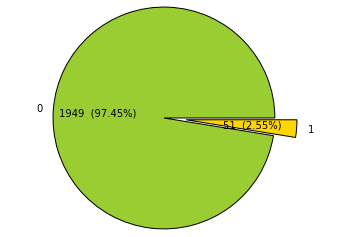

[SoftImpute] Max Singular Value of X_init = 93428318.713125
[SoftImpute] Iter 1: observed MAE=2515.933654 rank=4
[SoftImpute] Iter 2: observed MAE=2516.047092 rank=4
[SoftImpute] Iter 3: observed MAE=2516.147337 rank=4
[SoftImpute] Iter 4: observed MAE=2516.203889 rank=4
[SoftImpute] Iter 5: observed MAE=2516.237217 rank=4
[SoftImpute] Iter 6: observed MAE=2516.257686 rank=4
[SoftImpute] Iter 7: observed MAE=2516.270724 rank=4
[SoftImpute] Iter 8: observed MAE=2516.279314 rank=4
[SoftImpute] Iter 9: observed MAE=2516.285100 rank=4
[SoftImpute] Iter 10: observed MAE=2516.289075 rank=4
[SoftImpute] Iter 11: observed MAE=2516.291850 rank=4
[SoftImpute] Iter 12: observed MAE=2516.293811 rank=4
[SoftImpute] Iter 13: observed MAE=2516.295210 rank=4
[SoftImpute] Iter 14: observed MAE=2516.296217 rank=4
[SoftImpute] Iter 15: observed MAE=2516.296945 rank=4
[SoftImpute] Iter 16: observed MAE=2516.297475 rank=4
[SoftImpute] Iter 17: observed MAE=2516.297863 rank=4
[SoftImpute] Iter 18: observed 

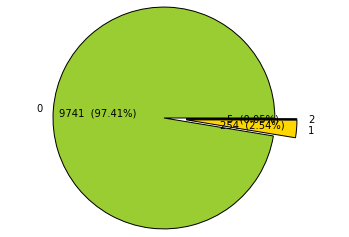

In [10]:
from fancyimpute import SoftImpute

for df in [validation, new_data]:
    data_no_cat = df.drop(obj_attr_names, axis=1)
    completed = SoftImpute().complete(data_no_cat)
    df[data_no_cat.columns] = completed
    plot_pie_nan_per_row(df)

In [11]:
verbose_flag = False
validation = impute_categories(validation,verbose_flag)
new_data = impute_categories(new_data,verbose_flag)

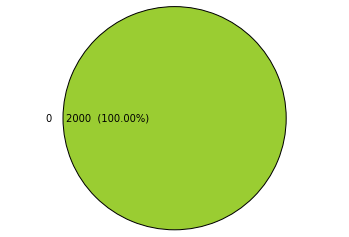

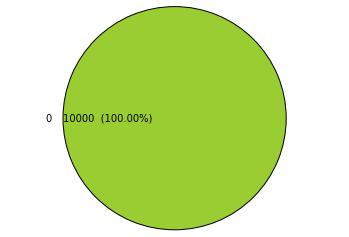

In [12]:
plot_pie_nan_per_row(validation)
plot_pie_nan_per_row(new_data)

# DONE WITH IMPUTATION!

Now let us convert the categorical features to one-hot vectors

In [13]:
validation = numerize(validation)
new_data = numerize(new_data)

In [14]:
def leave_only_important_features(df):
    features = df.columns.values
    important_features = ['Yearly_ExpensesK','Yearly_IncomeK','Overall_happiness_score',
    'Avg_Residancy_Altitude']
    important_features += [x for x in features if 'Most_Important_Issue' in x]
    important_features += [x for x in features if 'Will_vote_only_large_party' in x]
    important_features += [x for x in features if 'Financial_agenda_matters' in x]
    return df[important_features]

In [15]:
validation = leave_only_important_features(validation)
new_data = leave_only_important_features(new_data)

## Let's recap:

* We have used regression for the missing values.
* Imputed the missing categorical values.
* Left only the important features.

In [16]:
validation.to_csv('modified/validation_new.csv')
new_data.to_csv('modified/new_data_new.csv')

In [17]:
new_data

,Yearly_ExpensesK,Yearly_IncomeK,Overall_happiness_score,Avg_Residancy_Altitude,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Will_vote_only_large_party,Financial_agenda_matters
0,929.338910,781.073140,924.714426,40.201359,0,0,0,0,0,1,0,0,1.0,1.0
1,379.548186,556.695590,768.258370,62.931943,1,0,0,0,0,0,0,0,1.0,0.0
2,390.101442,556.362902,580.261538,161.675047,0,0,0,0,0,0,0,1,1.0,0.0
3,649.144205,548.702220,855.938949,340.660039,0,0,1,0,0,0,0,0,0.0,1.0
4,621.466780,606.605800,662.600631,44.874807,1,0,0,0,0,0,0,0,1.0,0.0
5,809.861427,556.685970,903.407967,105.016193,0,0,0,0,0,1,0,0,1.0,1.0
6,531.729008,643.184079,774.128812,82.700473,0,0,0,0,0,0,0,1,1.0,0.0
7,628.226533,666.715150,688.331566,315.242998,0,0,0,0,0,0,0,1,1.0,0.0
8,511.247275,678.160203,787.162512,38.577709,0,0,0,0,1,0,0,0,1.0,0.0
9,404.333333,699.401647,856.138206,86.839742,0,1,0,0,0,0,0,0,1.0,0.0


# Getting to the tasks...

### Here. We. Go!

We saw in HW3 that our Random Forest classifier gives us the best general accuracy which is the measure we are expected to maximize.

In HW3 have created several different classifiers, some are generative, others are descriminative. We then measured the different scores (f1, accuracy, recall, precision) that they achieved on the test set.

We do not want to overfit the model selection, we will not re-choose a model based on how well it performs on the validation set. We will use the Random Forest and use the validation set to measure its expected performance on the new data.

In the end, we will train a new Random Forest with the same parameters, but using all original data.

# Predict which party would win the majority of votes

Let's get the predictions of the classifier for the validation set, just to assess the accuracy.

In [18]:
validation_data = validation

In [19]:
validation

,Yearly_ExpensesK,Yearly_IncomeK,Overall_happiness_score,Avg_Residancy_Altitude,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Will_vote_only_large_party,Financial_agenda_matters
0,788.203786,612.552974,592.138627,136.149699,0,0,0,0,0,0,1,0,1.0,1.0
1,409.350627,576.583758,605.226716,305.992388,0,0,0,0,1,0,0,0,1.0,0.0
2,444.977057,628.083592,738.602654,62.258472,0,1,0,0,0,0,0,0,1.0,0.0
3,603.370492,658.483344,677.537898,139.310375,1,0,0,0,0,0,0,0,1.0,0.0
4,948.473156,941.675902,979.498786,234.793605,0,0,0,0,0,0,1,0,1.0,1.0
5,564.175526,642.479884,686.221338,93.894088,0,0,0,0,1,0,0,0,1.0,0.0
6,508.913666,663.369560,874.903020,104.073760,0,0,0,0,0,0,0,1,1.0,0.0
7,609.439552,653.776305,658.588262,198.616376,1,0,0,0,0,0,0,0,1.0,0.0
8,429.859484,576.989873,715.402598,63.505378,0,1,0,0,0,0,0,0,1.0,0.0
9,372.317057,718.206702,795.340242,340.853907,0,0,0,0,1,0,0,0,1.0,0.0


In [20]:
train_test2 = train_test.loc[train_test['Vote'].isin(['Yellows','Blues'])]
validation_data2 = validation.iloc[np.where(validation_labels.isin(['Yellows','Blues']))]
validation_labels2 = validation_labels.iloc[np.where(validation_labels.isin(['Yellows','Blues']))]

#Fit to the training and test set and predict on the validation set
train_test_data2 = train_test2.drop(['Vote'],axis=1)
train_test_labels2 = train_test2['Vote']
predictions2 = None
accuracy = 0
for i in range(30):
    if i%10==0:
        print i
    clf = RandomForestClassifier(n_estimators = 60,criterion='gini',n_jobs=-1)
    clf.fit(train_test_data2, train_test_labels2)
    predictions2 = clf.predict(validation_data2)
    accuracy += metrics.accuracy_score(validation_labels2, predictions2)
print "accuracy score:", accuracy/30

pred_counts = Counter(predictions2)
c = pred_counts.most_common()

parties, votes = zip(*[x for x in c])

pd.DataFrame(confusion_matrix(validation_labels2, predictions2, labels=parties), columns=parties, index=parties)



0
10
20
accuracy score: 0.878801498127


,Yellows,Blues
Yellows,485,64
Blues,46,295


In [21]:
#Fit to the training and test set and predict on the validation set
train_test_data = train_test.drop(['Vote'],axis=1)
train_test_labels = train_test['Vote']
predictions = None
accuracy = 0
for i in range(30):
    if i%10==0:
        print i
    clf = RandomForestClassifier(n_estimators = 60,criterion='gini',n_jobs=-1)
    clf.fit(train_test_data, train_test_labels)
    predictions = clf.predict(validation_data)
    accuracy += metrics.accuracy_score(validation_labels, predictions)
print "accuracy score:", accuracy/30

pred_counts = Counter(predictions)
c = pred_counts.most_common()

parties, votes = zip(*[x for x in c])

pd.DataFrame(confusion_matrix(validation_labels, predictions, labels=parties), columns=parties, index=parties)



0
10
20
accuracy score: 0.870833333333


,Yellows,Blues,Reds,Oranges,Greys,Whites,Greens,Pinks,Browns,Purples
Yellows,458,63,1,19,8,0,0,0,0,0
Blues,45,280,15,0,1,0,0,0,0,0
Reds,1,38,226,0,1,0,0,0,0,0
Oranges,8,0,0,191,17,0,0,0,0,0
Greys,8,2,0,14,159,0,0,0,0,0
Whites,0,0,0,0,0,119,2,3,0,0
Greens,0,0,0,0,0,0,113,4,0,0
Pinks,0,0,0,0,0,4,1,105,0,0
Browns,0,0,0,0,0,0,0,0,73,0
Purples,0,0,0,0,0,0,0,0,0,21


OK so now we have the accuracy for the validataion set. This is the accuracy we predict we will get on the new data.

Let's see how we predict the votes will be distributed between the parties.

First, let's train our classifier on all of the original data, because we don't need it anymore and any new training data is welcome.

In [22]:
train_test_validation_data = pd.concat([train_test_data, validation_data])
train_test_validation_labels = pd.concat([train_test_labels, validation_labels])

clf.fit(train_test_validation_data, train_test_validation_labels)

predictions = pd.Series(clf.predict(new_data))

new_data_with_predictions = pd.concat([new_data_IDs.rename('IdentityCard_Num'),predictions.rename('PredictVote'),new_data], axis=1)

In [23]:
new_data_with_predictions

,IdentityCard_Num,PredictVote,Yearly_ExpensesK,Yearly_IncomeK,Overall_happiness_score,Avg_Residancy_Altitude,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Will_vote_only_large_party,Financial_agenda_matters
0,1,Pinks,929.338910,781.073140,924.714426,40.201359,0,0,0,0,0,1,0,0,1.0,1.0
1,2,Oranges,379.548186,556.695590,768.258370,62.931943,1,0,0,0,0,0,0,0,1.0,0.0
2,3,Yellows,390.101442,556.362902,580.261538,161.675047,0,0,0,0,0,0,0,1,1.0,0.0
3,4,Purples,649.144205,548.702220,855.938949,340.660039,0,0,1,0,0,0,0,0,0.0,1.0
4,5,Greys,621.466780,606.605800,662.600631,44.874807,1,0,0,0,0,0,0,0,1.0,0.0
5,6,Pinks,809.861427,556.685970,903.407967,105.016193,0,0,0,0,0,1,0,0,1.0,1.0
6,7,Yellows,531.729008,643.184079,774.128812,82.700473,0,0,0,0,0,0,0,1,1.0,0.0
7,8,Reds,628.226533,666.715150,688.331566,315.242998,0,0,0,0,0,0,0,1,1.0,0.0
8,9,Yellows,511.247275,678.160203,787.162512,38.577709,0,0,0,0,1,0,0,0,1.0,0.0
9,10,Reds,404.333333,699.401647,856.138206,86.839742,0,1,0,0,0,0,0,0,1.0,0.0


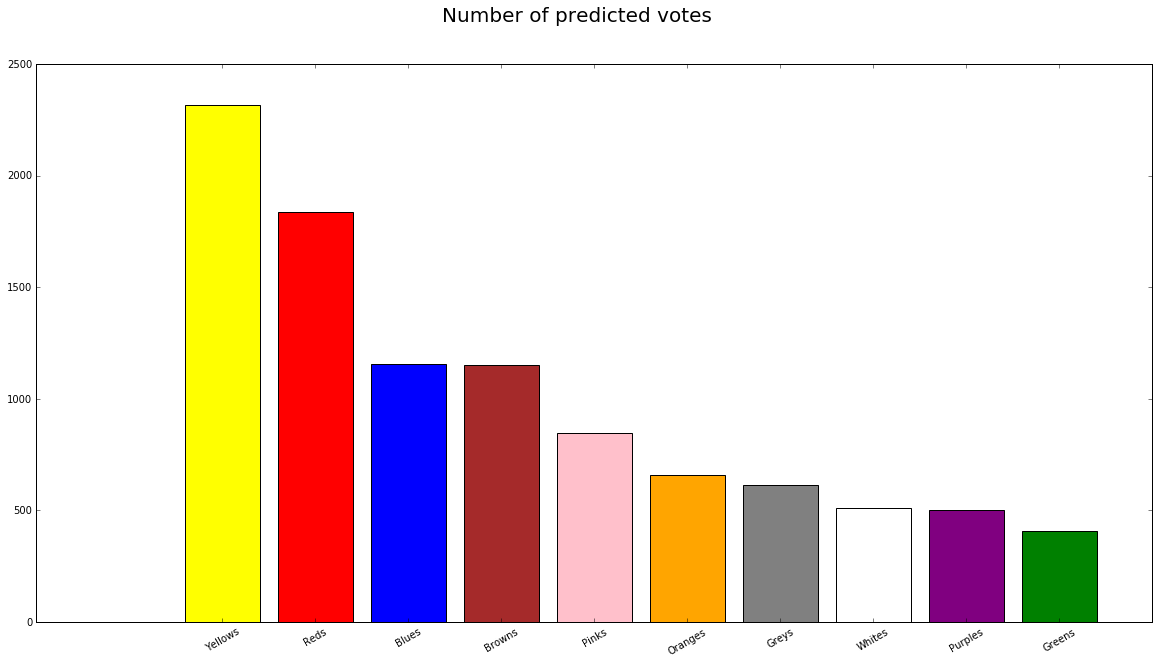

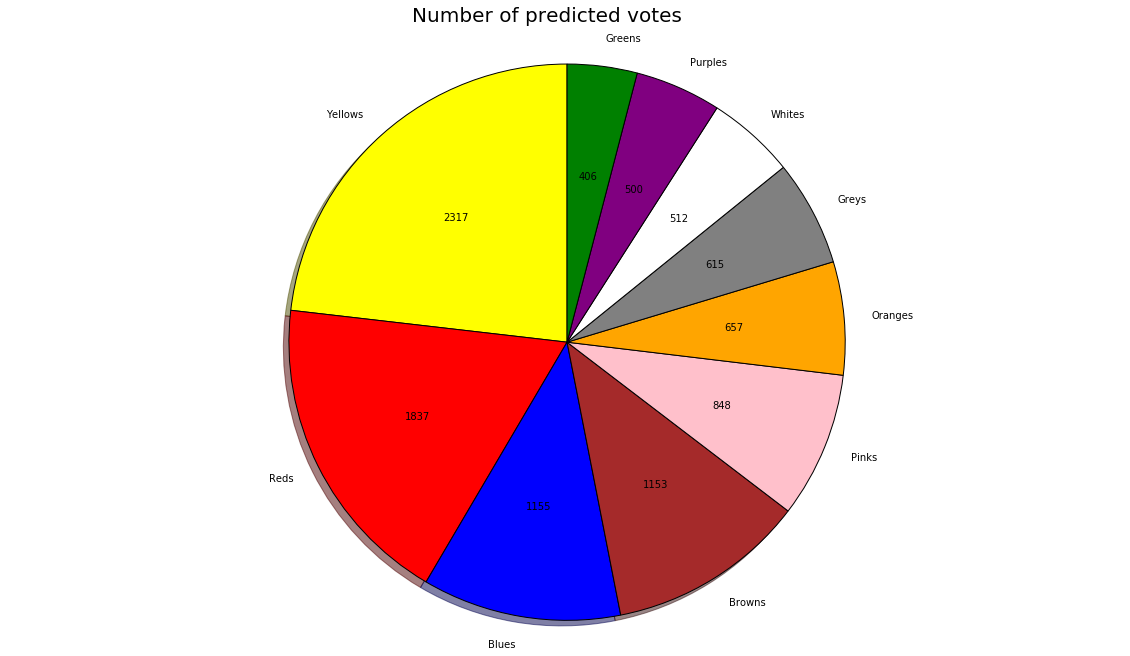

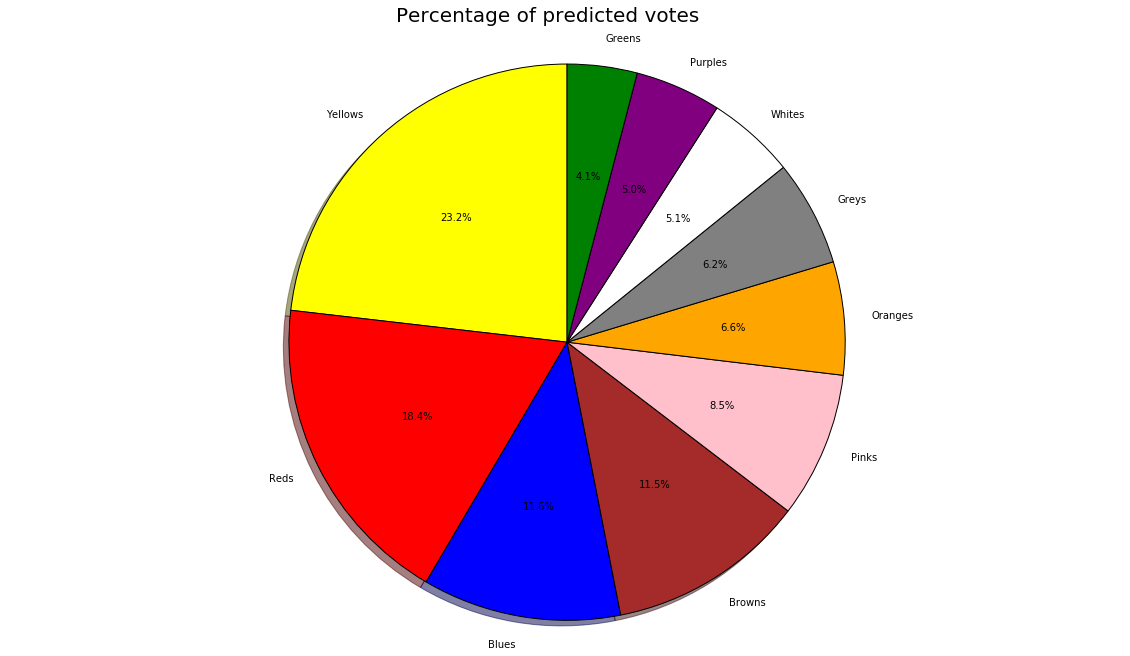

In [24]:
pred_counts = Counter(predictions)
c = pred_counts.most_common()

parties, votes = zip(*[x for x in c])

colors = [x[:-1] for x in parties] ###[x[:-1] if x != 'Whites' else 'navajowhite' for x in parties]

f, ax = plt.subplots(figsize=(20, 10))
f.suptitle('Number of predicted votes',fontsize=20)
ax.bar(range(len(c)), [x[1] for x in c], align="center",color=colors)
plt.xticks(range(len(c)), parties, rotation=30)

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.pie([x[1] for x in c], labels=parties, colors=colors, autopct=lambda(p): '{:.0f}'.format(p * predictions.size / 100),
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.suptitle('Number of predicted votes',fontsize=20)

total_votes = new_data_with_predictions.shape[0]
ratios = [float(v)/total_votes for v in votes]
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.pie(ratios, labels=parties, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
fig2.suptitle('Percentage of predicted votes',fontsize=20)

plt.show()

This is our predicted distribution of votes. We predict the party with the most votes will win the election.

# List of most probable voters

In [25]:
party_to_voters = {}

for party in clf.classes_:
    party_to_voters[party] = new_data_with_predictions.iloc[np.where(predictions == party)[0]]

party_to_voters will hold for each party, the people that the classifier predicted will vote to that party.

For example:

In [26]:
party_to_voters['Greens']

,IdentityCard_Num,PredictVote,Yearly_ExpensesK,Yearly_IncomeK,Overall_happiness_score,Avg_Residancy_Altitude,Most_Important_Issue_Education,Most_Important_Issue_Environment,Most_Important_Issue_Financial,Most_Important_Issue_Foreign_Affairs,Most_Important_Issue_Healthcare,Most_Important_Issue_Military,Most_Important_Issue_Other,Most_Important_Issue_Social,Will_vote_only_large_party,Financial_agenda_matters
41,42,Greens,791.731643,904.060830,731.285518,106.939382,0,0,0,1,0,0,0,0,1.0,1.0
55,56,Greens,701.012893,632.795988,569.452750,67.186101,0,0,0,0,0,0,1,0,1.0,1.0
57,58,Greens,999.883417,893.871772,750.533354,26.182201,0,0,0,0,0,0,1,0,1.0,1.0
99,100,Greens,803.767750,677.374733,255.209786,70.691367,0,0,0,1,0,0,0,0,1.0,1.0
111,112,Greens,255.060779,473.388937,193.835865,110.012545,0,0,0,0,0,0,1,0,1.0,1.0
122,123,Greens,881.944804,853.804899,847.134359,146.324082,0,0,0,0,0,0,1,0,1.0,1.0
128,129,Greens,972.189192,634.549346,284.926025,44.500245,0,0,0,1,0,0,0,0,1.0,1.0
141,142,Greens,939.805834,934.748230,883.773095,113.721943,0,0,0,0,0,0,1,0,1.0,1.0
149,150,Greens,466.957849,633.269606,446.963048,338.312560,0,0,0,0,0,0,1,0,1.0,1.0
160,161,Greens,880.284639,968.765023,495.706699,25.079907,0,0,0,0,0,0,1,0,1.0,1.0


In [27]:
new_data_with_predictions[["IdentityCard_Num","PredictVote"]].to_csv("results/final_prediction.csv", index=False)

# Steady Coalition [automatic process - just the same as HW4]

After predicting which voters will vote to which party, we wish to predict a steady coalition, which in our terms will mean dividing the 7-dimension-hyperspace into 2 groups, clusters, the bigger of which will be the coalition and the smaller one is the opposition.

but - we cannot just take any division of the voters, because a coalition consists of whole parties and not individual voters, so our each of our clusters must properly contain whole parties (meaning - all predicted voters for that party).

we'll need to devise some single scoring function that can rank such a division, based on how homogeneous the coalition is, and how far it is from the opposition.

technically, given this score can be calculated in a short time, we can try all possible party combinations (just 2^10, 1024, options, at least half of which will not actually be a valid coalition with 51% or more votes), and choose the one with the highest score - but we'll try a smarter approach, somewhat similar to Agglomerative clustering - starting with 10 clusters, one for each party, then unifying clusters greedily based on some measurement (e.g. - the two "closest" clusters) until we are left with only two - the larger of which will be the coalition (assuming it will have more then 51% of votes).

In [28]:
def get_opposition_for_coalition(coalition):
    coalition = set(coalition)
    opposition = set(party_names) - coalition
    return opposition

def get_voters_mask_for_cluster(full_data, cluster):
    labels = full_data['PredictVote']
    cluster_mask = np.zeros(len(labels), dtype=bool) # all False
    for party in cluster:
        cluster_mask = np.logical_or(cluster_mask, labels==party)
    return cluster_mask

def get_voters_for_cluster(full_data, cluster):
    cluster_mask = get_voters_mask_for_cluster(full_data, cluster)
    cluster_data = full_data[cluster_mask].drop(['PredictVote'],axis=1)
    return cluster_data

numerical_attrs = ['Yearly_ExpensesK', 'Yearly_IncomeK', 'Overall_happiness_score', 'Avg_Residancy_Altitude']

def scale(df):
    for attr in numerical_attrs:
        min_v = min([v for v in df[attr]])
        for i in df.index.values:
            df[attr][i] = math.log1p(df[attr][i]-min_v)
        max_v = max([v for v in df[attr]])
        for i in df.index.values:
            df[attr][i] /= (10**math.ceil(math.log10(max_v)))
        df[attr].plot(kind='kde')
        plt.show()
    return df

def calc_homogeneity_of_cluster(full_data, cluster):
    distance_to_self = calc_distance_between_clusters(full_data, cluster, cluster)
    return (10-distance_to_self)*100 # Norm of this measurement, tranformed to 0-1000 (higher is better)

def calc_distance_between_clusters(full_data, cluster_1, cluster_2):
    c1_data = get_voters_for_cluster(full_data, cluster_1)
    c2_data = get_voters_for_cluster(full_data, cluster_2)
    return np.mean([np.linalg.norm(np.array(v1[1:])-np.array(v2[1:])) for v1 in c1_data.itertuples() for v2 in c2_data.itertuples()])            

def calc_distance_between_coalition_to_opposition(full_data, coalition):
    coalition = set(coalition)
    opposition = get_opposition_for_coalition(coalition)
    return calc_distance_between_clusters(full_data, coalition, opposition)*100

def calc_coalition_score(full_data, coalition):
    coal_voters = get_voters_for_cluster(full_data, coalition)
    if (coal_voters.shape[0] < 51.0*full_data.shape[0]/100.0):
        return -1000.0 # provided coalition is less than 51%, not legal, so we give a negative score.
    hmg_score = calc_homogeneity_of_cluster(full_data, coalition)
    dst_score = calc_distance_between_coalition_to_opposition(full_data, coalition)
    return hmg_score + dst_score # Considering some weighted mean (need to figure out favoring what? hmg or dst..? and why?)

now that we've got all our business logic in-place, time to assemble a coalition!

we'll use the algorithm called **"[Agglomerative clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering?oldformat=true#Agglomerative_clustering_example)"**, which is type of heirarchial clustering, BUT - we will not use it to cluster *voters* together, we will cluster *whole parties* [because, unfortunately, a coalition consists of entire parties :( ]

we are going to start with 10 "candidate coalitions", each contains only a single party,
then - we are going to greedily unify those "candidate coalitions" by measure of cluster distance, until we are left with 2 clusters only (meaning 8 unification steps). the larger of which will be the coalition.

We believe this will give a very homogenous coalition, which is as far as possible from the opposition, intuitively - if any party was "on the wrong side" (meaning an opposition party that joined the coalition would make it stronger, or a coalition party leaving for the opposition would make the coalition stronger), then it should've found itself on the other cluster than it did - meaning it was further away from that cluster than from the one it did eventually join

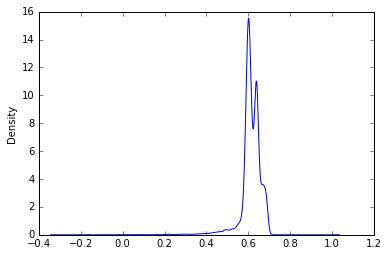

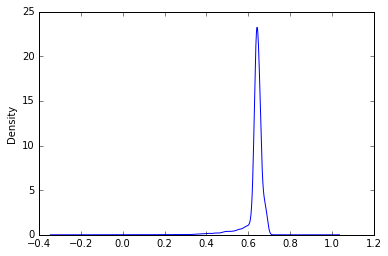

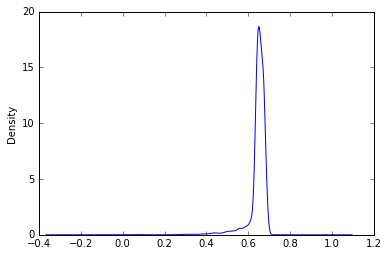

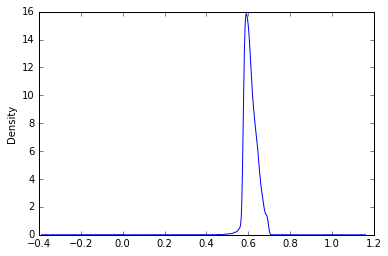

1 	closest cluster pair:	((7, ('Whites',)), (9, ('Greens',)))
2 	closest cluster pair:	((4, ('Pinks',)), (7, ('Whites', 'Greens')))
3 	closest cluster pair:	((5, ('Oranges',)), (6, ('Greys',)))
4 	closest cluster pair:	((2, ('Blues',)), (5, ('Oranges', 'Greys')))
5 	closest cluster pair:	((0, ('Yellows',)), (2, ('Blues', 'Oranges', 'Greys')))
6 	closest cluster pair:	((0, ('Yellows', 'Blues', 'Oranges', 'Greys')), (1, ('Reds',)))
7 	closest cluster pair:	((0, ('Yellows', 'Blues', 'Oranges', 'Greys', 'Reds')), (1, ('Browns',)))
8 	closest cluster pair:	((1, ('Pinks', 'Whites', 'Greens')), (2, ('Purples',)))


In [29]:
new_data_with_predictions_no_ids = scale(new_data_with_predictions.drop(['IdentityCard_Num'],axis=1))

@lru_cache(maxsize=32*1024) # an attribute for memoization, because we are going to compare similar clusters many times.
def calc_distance_between_clusters_in_new_data(cluster_1, cluster_2):
    return calc_distance_between_clusters(new_data_with_predictions_no_ids, cluster_1, cluster_2)

from itertools import combinations
cand_cols = [(name,) for name in parties]
for r in range(len(parties)-2):
    all_cluster_pairs = combinations(enumerate(cand_cols), 2) # they are also numbered... [((1,c1),(2,c2)),...,...]
    closest_cluster_pair = min(all_cluster_pairs, key=lambda t: calc_distance_between_clusters_in_new_data(t[0][1], t[1][1]))
    print r+1,"\tclosest cluster pair:\t",closest_cluster_pair
    new_cluster = closest_cluster_pair[0][1] + closest_cluster_pair[1][1]
    del cand_cols[closest_cluster_pair[1][0]] # delete one of the old clusters
    cand_cols[closest_cluster_pair[0][0]] = new_cluster # replace the other one with the unified

In [30]:
cand_cols

[('Yellows', 'Blues', 'Oranges', 'Greys', 'Reds', 'Browns'),
 ('Pinks', 'Whites', 'Greens', 'Purples')]

In [31]:
coalition = max(cand_cols, key=lambda c: len(get_voters_for_cluster(new_data_with_predictions_no_ids, c))) # take the larger out of the two clusters
coalition

('Yellows', 'Blues', 'Oranges', 'Greys', 'Reds', 'Browns')

In [32]:
# let's print out a few stats about our coalition:
def print_coalition_nums(full_data, coalition):
    print "The coalition consists of the following parties:",coalition
    print "The coalition contains",len(get_voters_for_cluster(full_data, coalition)), "voters out of total",len(full_data)
    print "Which means it gets",(len(get_voters_for_cluster(full_data, coalition)) / float(len(full_data)))*100,"% of all votes"

def print_coalition_scores(full_data, coalition):
    print "The homogenity score for this colaition is:",calc_homogeneity_of_cluster(full_data, coalition)
    print "The distance from it to the opposition is:",calc_distance_between_coalition_to_opposition(full_data, coalition)
    print ".... so the overall coalition score is:",calc_coalition_score(full_data, coalition)

print_coalition_nums(new_data_with_predictions_no_ids, coalition)
print ""
#print_coalition_scores(new_data_with_predictions_no_ids, coalition)

The coalition consists of the following parties: ('Yellows', 'Blues', 'Oranges', 'Greys', 'Reds', 'Browns')
The coalition contains 7734 voters out of total 10000
Which means it gets 77.34 % of all votes

